# Building Robust RAG Pipelines: Integrating Google's Gemma 2 2B Open Model, MongoDB, and LLM Evaluation Techniques

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/rag/rag_with_gemma2_2b_mongodb_open_models.ipynb)


## Step 1: Install libaries and Set Environment Variables


In [1]:
!pip install --upgrade --quiet datasets pandas pymongo sentence_transformers deepeval

In [2]:
import os
os.environ["HF_TOKEN"] = ""
os.environ["OPENAI_API_KEY"] = "" # Need this for the evaluation step

## Step 2: Data Loading and Preparation

Dataset Information

This [dataset](https://huggingface.co/datasets/MongoDB/fake_tech_companies_market_reports) contains detailed information about multiple technology companies in the Information Technology sector. For each company, the dataset includes:

1. Company name and stock ticker symbol
2. Market analysis reports for recent years (typically 2023 and 2024), which include:
- Title and author of the report
- Date of publication
- Detailed content covering financial performance, product innovations, market position, challenges, and future outlook
- Stock recommendations and price targets
3. Key financial metrics such as:
- Current stock price
- 52-week price range
- Market capitalization
- Price-to-earnings (P/E) ratio
- Dividend yield
4. Recent news items, typically including:
- Date of the news
- Headline
- Brief summary

The market analysis reports provide in-depth information about each company's performance, innovations, challenges, and future prospects. They offer insights into the companies' strategies, market positions, and potential for growth.


In [3]:
import pandas as pd
from datasets import load_dataset

# Make sure you have an Hugging Face token(HF_TOKEN) in your development environemnt before running the code below
# How to get a token: https://huggingface.co/docs/hub/en/security-tokens
# https://huggingface.co/datasets/MongoDB/fake_tech_companies_market_reports
dataset = load_dataset("MongoDB/fake_tech_companies_market_reports", split="train", streaming=True)
dataset_df = dataset.take(100)

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset_df)
dataset_df.head(5)

,recent_news,reports,company,ticker,key_metrics,sector
0,"[{'date': '2024-06-09', 'headline': 'CyberDefe...","[{'author': 'Taylor Smith, Technology Sector L...",CyberDefense Dynamics,CDDY,"{'52_week_range': {'high': 387.3, 'low': 41.63...",Information Technology
1,"[{'date': '2024-07-04', 'headline': 'CloudComp...","[{'author': 'Casey Jones, Chief Market Strateg...",CloudCompute Pro,CCPR,"{'52_week_range': {'high': 524.23, 'low': 171....",Information Technology
2,"[{'date': '2024-06-27', 'headline': 'VirtualRe...","[{'author': 'Sam Brown, Head of Equity Researc...",VirtualReality Systems,VRSY,"{'52_week_range': {'high': 530.59, 'low': 56.4...",Information Technology
3,"[{'date': '2024-07-06', 'headline': 'BioTech I...","[{'author': 'Riley Smith, Senior Tech Analyst'...",BioTech Innovations,BTCI,"{'52_week_range': {'high': 366.55, 'low': 124....",Information Technology
4,"[{'date': '2024-06-26', 'headline': 'QuantumCo...","[{'author': 'Riley Garcia, Senior Tech Analyst...",QuantumComputing Inc,QCMP,"{'52_week_range': {'high': 231.91, 'low': 159....",Information Technology


In [4]:
# Data Preparation
def combine_attributes(row):
  """
  Combine the attributes of a row into a single string.
  """
  combined = f"{row['company']} {row['sector']} "

  # Add reports information
  for report in row['reports']:
    combined += f"{report['year']} {report['title']} {report['author']} {report['content']} "

  # Add recent news information
  for news in row['recent_news']:
    combined += f"{news['headline']} {news['summary']} "

  return combined.strip()

In [5]:
# Add the new column 'combined_attributes'
dataset_df['combined_attributes'] = dataset_df.apply(combine_attributes, axis=1)

In [6]:
# Display the first few rows of the updated dataframe
dataset_df[['company', 'ticker', 'combined_attributes']].head()

,company,ticker,combined_attributes
0,CyberDefense Dynamics,CDDY,CyberDefense Dynamics Information Technology 2...
1,CloudCompute Pro,CCPR,CloudCompute Pro Information Technology 2023 C...
2,VirtualReality Systems,VRSY,VirtualReality Systems Information Technology ...
3,BioTech Innovations,BTCI,BioTech Innovations Information Technology 202...
4,QuantumComputing Inc,QCMP,QuantumComputing Inc Information Technology 20...


## Step 3: Embedding Generation with GTE-Large


In [76]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# Load the model
# https://huggingface.co/thenlper/gte-large
# embedding_model = SentenceTransformer('thenlper/gte-large')
embedding_model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)

# Determine the maximum sequence length for the model
max_seq_length = embedding_model.max_seq_length

def chunk_text(text, tokenizer, max_length=8192, overlap=50):
    """
    Split the text into overlapping chunks based on token length.
    """
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_length - overlap):
        chunk_tokens = tokens[i:i + max_length]
        chunk = tokenizer.convert_tokens_to_string(chunk_tokens)
        chunks.append(chunk)
    return chunks

def get_embedding(input_data):
    """
    Generate embeddings for the 'combined_attributes' column and duplicate the row for each chunk
    or generate embeddings for a given string.
    """
    if isinstance(input_data, str):
        text = input_data
    else:
        text = input_data['combined_attributes']

    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    # Get the tokenizer from the model
    tokenizer = embedding_model.tokenizer

    # Split text into chunks if it's too long
    chunks = chunk_text(text, tokenizer, max_length=max_seq_length)

    # Embed each chunk
    chunk_embeddings = embedding_model.encode(chunks)

    if isinstance(input_data, str):
        # Return list of embeddings for string input
        return [embedding.tolist() for embedding in chunk_embeddings][0]
    else:
        # Create duplicated rows for each chunk with the respective embedding for row input
        duplicated_rows = []
        for embedding in chunk_embeddings:
            new_row = input_data.copy()
            new_row['embedding'] = embedding.tolist()
            duplicated_rows.append(new_row)
        return duplicated_rows

# Apply the function and expand the dataset
duplicated_data = []
for _, row in tqdm(dataset_df.iterrows(), desc="Generating embeddings and duplicating rows", total=len(dataset_df)):
    duplicated_rows = get_embedding(row)
    duplicated_data.extend(duplicated_rows)

# Create a new DataFrame from the duplicated data
dataset_df = pd.DataFrame(duplicated_data)


Generating embeddings and duplicating rows: 100%|██████████| 63/63 [00:08<00:00,  7.49it/s]


In [77]:
dataset_df.head()

,recent_news,reports,company,ticker,key_metrics,sector,combined_attributes,embedding
0,"[{'date': '2024-06-09', 'headline': 'CyberDefe...","[{'author': 'Taylor Smith, Technology Sector L...",CyberDefense Dynamics,CDDY,"{'52_week_range': {'high': 387.3, 'low': 41.63...",Information Technology,CyberDefense Dynamics Information Technology 2...,"[0.975287139415741, -0.512822687625885, 0.0258..."
1,"[{'date': '2024-07-04', 'headline': 'CloudComp...","[{'author': 'Casey Jones, Chief Market Strateg...",CloudCompute Pro,CCPR,"{'52_week_range': {'high': 524.23, 'low': 171....",Information Technology,CloudCompute Pro Information Technology 2023 C...,"[0.7592194080352783, -0.4812052547931671, -0.0..."
2,"[{'date': '2024-06-27', 'headline': 'VirtualRe...","[{'author': 'Sam Brown, Head of Equity Researc...",VirtualReality Systems,VRSY,"{'52_week_range': {'high': 530.59, 'low': 56.4...",Information Technology,VirtualReality Systems Information Technology ...,"[1.3058077096939087, -0.46789678931236267, 0.0..."
3,"[{'date': '2024-07-06', 'headline': 'BioTech I...","[{'author': 'Riley Smith, Senior Tech Analyst'...",BioTech Innovations,BTCI,"{'52_week_range': {'high': 366.55, 'low': 124....",Information Technology,BioTech Innovations Information Technology 202...,"[0.25378385186195374, -0.47685152292251587, 0...."
4,"[{'date': '2024-06-26', 'headline': 'QuantumCo...","[{'author': 'Riley Garcia, Senior Tech Analyst...",QuantumComputing Inc,QCMP,"{'52_week_range': {'high': 231.91, 'low': 159....",Information Technology,QuantumComputing Inc Information Technology 20...,"[0.3205534517765045, -0.8558124303817749, -0.7..."


## Step 4: MongoDB Vector Database and Connection Setup


MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.
3. Create the database: `asset_management_use_case`.
4. Within the database ` asset_management_use_case`, create the collection `market_reports`.
5. Create a [vector search index](https://www.mongodb.com/docs/atlas/atlas-vector-search/create-index/#procedure/) named vector_index for the ‘listings_reviews’ collection. This index enables the RAG application to retrieve records as additional context to supplement user queries via vector search. Below is the JSON definition of the data collection vector search index.

Your vector search index created on MongoDB Atlas should look like below:

```
{
  "fields": [
    {
      "numDimensions": 1024,
      "path": "embedding",
      "similarity": "cosine",
      "type": "vector"
    }
  ]
}

```

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [78]:
import os
os.environ["MONGO_URI"] = ""

In [79]:
import pymongo

def get_mongo_client(mongo_uri):
  """Establish and validate connection to the MongoDB."""

  client = pymongo.MongoClient(mongo_uri, appname="devrel.showcase.rag.gemma_2_2b.python")

  # Validate the connection
  ping_result = client.admin.command('ping')
  if ping_result.get('ok') == 1.0:
    # Connection successful
    print("Connection to MongoDB successful")
    return client
  else:
    print("Connection to MongoDB failed")
  return None

MONGO_URI = os.environ["MONGO_URI"]

if not MONGO_URI:
  print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "asset_management_use_case"
COLLECTION_NAME = "market_reports"

db = mongo_client.get_database(DB_NAME)
collection = db.get_collection(COLLECTION_NAME)

Connection to MongoDB successful


In [80]:
# Delete any existing records in the collection
collection.delete_many({})

DeleteResult({'n': 63, 'electionId': ObjectId('7fffffff000000000000002d'), 'opTime': {'ts': Timestamp(1722447550, 63), 't': 45}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1722447550, 63), 'signature': {'hash': b'\xfd\x97V\xd5\xa7\x99\xa6\\\xd6M^\xa4\xc9\x82\x15\xfcgP\xd3\x8e', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1722447550, 63)}, acknowledged=True)

## Step 5: Data Ingestion

MongoDB's Document model and its compatibility with Python dictionaries offer several benefits for data ingestion.

* Document-oriented structure:
  * MongoDB stores data in JSON-like documents: BSON(Binary JSON).
  * This aligns naturally with Python dictionaries, allowing for seamless data representation using key value pair data structures.
* Schema flexibility:
  * MongoDB is schema-less, meaning each document in a collection can have a different structure.
  * This flexibility matches Python's dynamic nature, allowing you to ingest varied data structures without predefined schemas.
* Efficient ingestion:
  * The similarity between Python dictionaries and MongoDB documents allows for direct ingestion without complex transformations.
  * This leads to faster data insertion and reduced processing overhead.

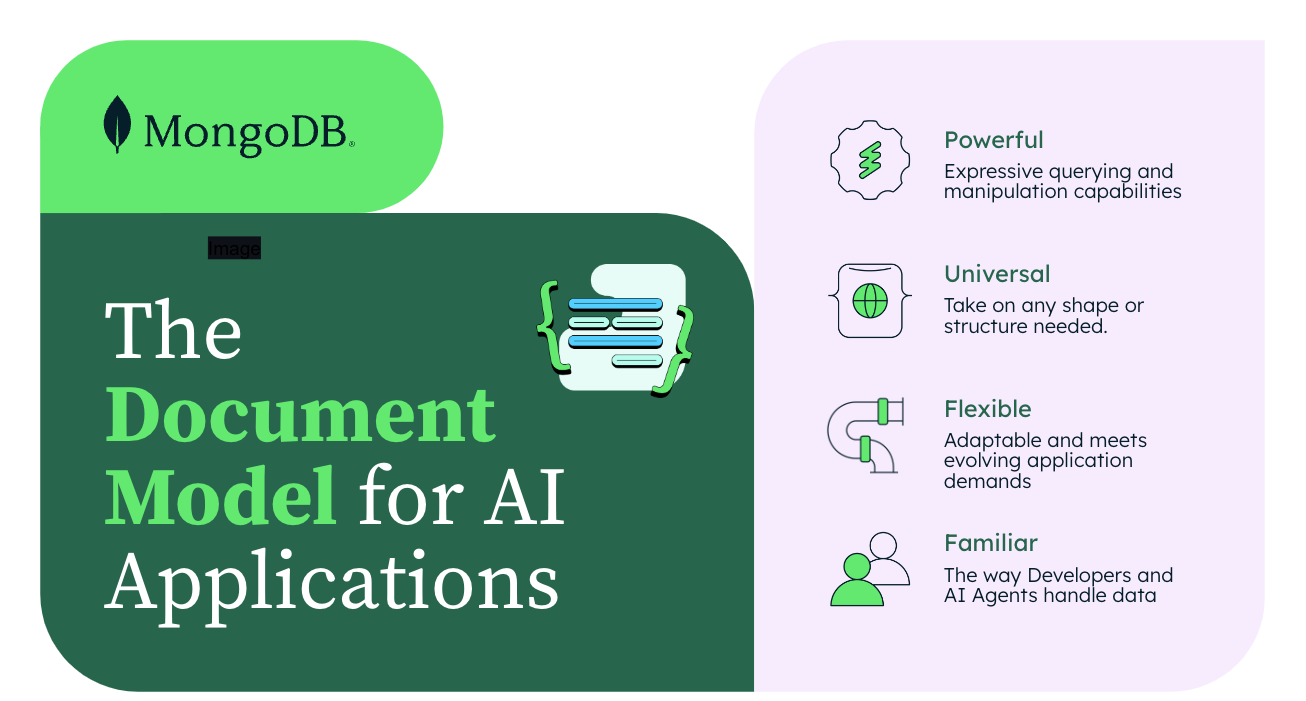

In [81]:
documents = dataset_df.to_dict('records')
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Step 6: MongoDB Query language and Vector Search

**Query flexibility**

MongoDB's query language is designed to work well with document structures, making it easy to query and manipulate ingested data using familiar Python-like syntax.


**Aggregation Pipeline**

MongoDB's aggregation pipelines is a powerful feature of the MongoDB Database that allows for complex data processing and analysis within the database.
Aggregation pipeline can be thought of similarly to pipelines in data engineering or machine learning, where processes operate sequentially, each stage taking an input, performing operations, and providing an output for the next stage.

**Stages**

Stages are the building blocks of an aggregation pipeline.
Each stage represents a specific data transformation or analysis operation.
Common stages include:
  - `$match`: Filters documents (similar to WHERE in SQL)
  - `$group`: Groups documents by specified fields
  - `$sort`: Sorts the documents
  - `$project`: Reshapes documents (select, rename, compute fields)
  - `$limit`: Limits the number of documents
  - `$unwind`: Deconstructs array fields
  - `$lookup`: Performs left outer joins with other collections



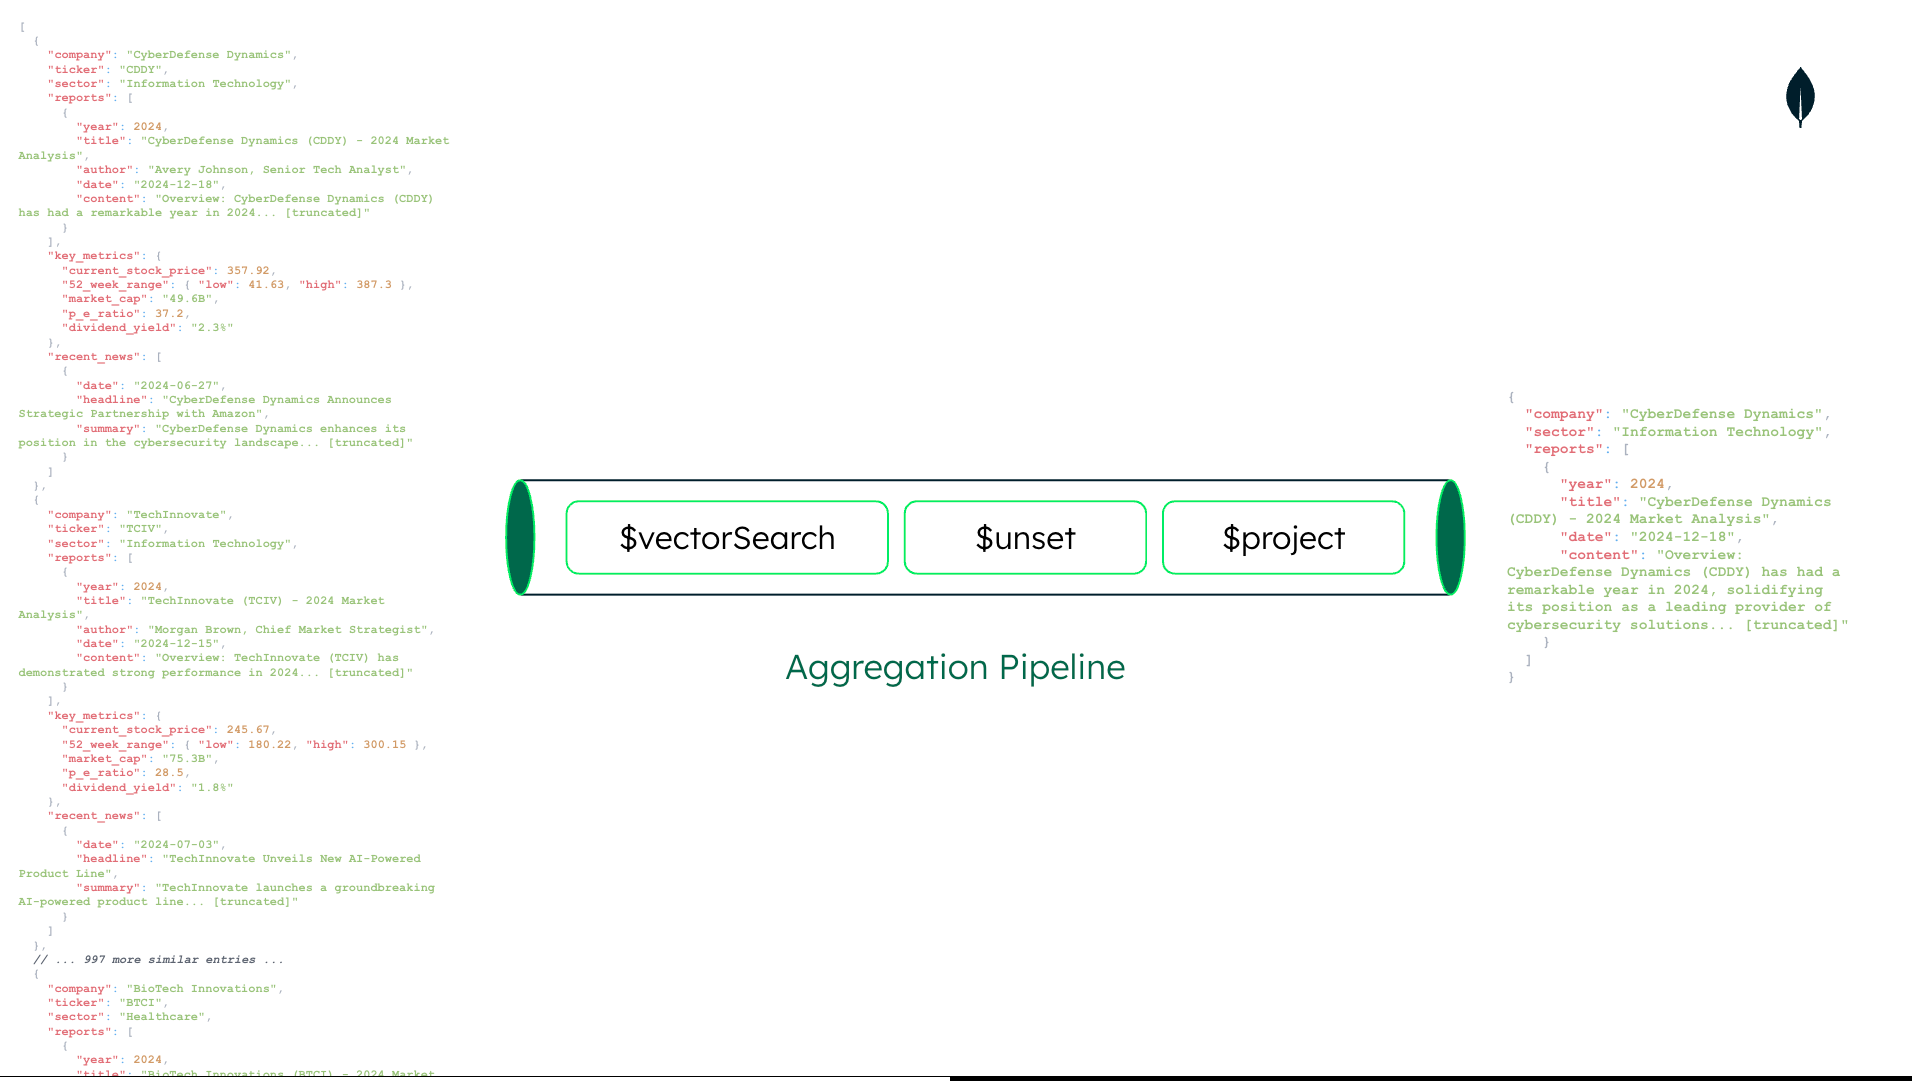

In [82]:
def vector_search(user_query, collection):
  """
  Perform a vector search in the MongoDB collection based on the user query.

  Args:
  user_query (str): The user's query string.
  collection (MongoCollection): The MongoDB collection to search.

  Returns:
  list: A list of matching documents.
  """

  # Generate embedding for the user query
  query_embedding = get_embedding(user_query)

  if query_embedding is None:
    return "Invalid query or embedding generation failed."

  # Define the vector search pipeline
  vector_search_stage = {
    "$vectorSearch": {
      "index": "vector_index",
      "queryVector": query_embedding,
      "path": "embedding",
      "numCandidates": 150,  # Number of candidate matches to consider
      "limit": 2  # Return top 4 matches
    }
  }

  unset_stage = {
    "$unset": "embedding"  # Exclude the 'embedding' field from the results
  }

  project_stage = {
    "$project": {
      "_id": 0,  # Exclude the _id field
      "company": 1,  # Include the plot field
      "reports": 1,  # Include the title field
      "combined_attributes": 1, # Include the genres field
      "score": {
        "$meta": "vectorSearchScore"  # Include the search score
      }
    }
  }

  pipeline = [vector_search_stage, unset_stage, project_stage]

  # Execute the search
  results = collection.aggregate(pipeline)
  return list(results)


## Step 8: Handling User Queries


In [88]:
def get_search_result(query, collection):

  get_knowledge = vector_search(query, collection)

  search_result = ''
  for result in get_knowledge:
      search_result += f"Company: {result.get('company', 'N/A')}, Combined Attributes: {result.get('combined_attributes', 'N/A')}\n"

  return search_result

In [89]:
# Conduct query with retrieval of sources
query = "Select a company from the provided information that is safe to invest in for the long term, and provide a reason"
source_information = get_search_result(query, collection)
combined_information = f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."

print(combined_information)

Query: Select a company from the provided information that is safe to invest in for the long term, and provide a reason
Continue to answer the query by using the Search Results:
Company: CyberDefense Dynamics, Combined Attributes: CyberDefense Dynamics Information Technology 2023 CyberDefense Dynamics (CDDY) - 2023 Market Analysis Taylor Smith, Technology Sector Lead **CyberDefense Dynamics (CDDY) - 2023 Market Analysis Report**

**Overview:**
CyberDefense Dynamics (CDDY) is a leading provider of cybersecurity solutions, offering a range of products and services to protect businesses and government agencies from digital threats. In 2023, CDDY continued to strengthen its market position and delivered solid performance despite a challenging economic environment. This report provides an in-depth analysis of CDDY's performance in 2023, highlighting its key achievements, financial performance, challenges, and future prospects.

**Key Highlights:**

- **Financial Performance:** CDDY reported

## Step 9: Load Gemma 2

In [90]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [91]:
def extract_model_response(response):
  # Split the response at the start of the model's turn
  parts = response.split("<start_of_turn>model")

  # If there's a model response, it will be in the last part
  if len(parts) > 1:
    model_response = parts[-1].strip()

    # Remove any potential end-of-turn markers
    model_response = model_response.split("<end_of_turn>")[0].strip()

    return model_response
  else:
    return "No model response found."

In [92]:
chat = [
    { "role": "user", "content": combined_information },
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
outputs = model.generate(input_ids=inputs.to(model.device), max_new_tokens=500, do_sample=True, temperature=0.7)

response = tokenizer.decode(outputs[0])

In [93]:
model_output = extract_model_response(response)
print(model_output)

Based on the provided information, **CyberDefense Dynamics (CDDY)** appears to be the safer investment option for the long term. Here's why:

* **Strong Financial Performance:** CDDY demonstrated consistent, healthy revenue growth and profitability in recent years. They are already reporting strong earnings in 2024, indicating a solid foundation for continued success.
* **Market Leadership:** CDDY holds a dominant position in the cybersecurity market, particularly in North America. Their reputation for robust and innovative security solutions is reflected in their expanding customer base and market share.
* **Strategic Acquisitions:** CDDY's strategic acquisitions in 2023 enhance their capabilities and expand their market reach. These acquisitions demonstrate their commitment to staying ahead in a competitive industry.
* **Innovation & R&D:** CDDY is actively investing in R&D, focusing on areas like AI-powered threat detection and cloud security. This proactive approach keeps them at t

## Step 10: LLM Evaluation (Generation Component)

In [94]:
from deepeval import evaluate
from deepeval.test_case import LLMTestCase

## Answer Relevance

In [95]:
from deepeval.metrics import AnswerRelevancyMetric

actual_output = model_output

metric = AnswerRelevancyMetric(
    threshold=0.7,
    model="gpt-4",
    include_reason=True
)

test_case = LLMTestCase(
    input=query,
    actual_output=actual_output
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

1.0
The score is 1.00 because the response accurately selected a company from the provided information and justified why it's a safe long-term investment, addressing all aspects of the input.


## Faithfulness

In [96]:
from deepeval.metrics import FaithfulnessMetric

actual_output = model_output

retrieval_context = [source_information]

metric = FaithfulnessMetric(
    threshold=0.7,
    model="gpt-4",
    include_reason=True
)
test_case = LLMTestCase(
    input=query,
    actual_output=actual_output,
    retrieval_context=retrieval_context
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

0.9333333333333333
The score is 0.93 because there is a minor discrepancy with the year of CDDY's strategic acquisitions. The actual output mistakenly indicates they occurred in 2023 while the context clearly states they happened in 2024.


## Step 11: Content Moderation Using ShieldGemma

In [ ]:
shield_tokenizer = AutoTokenizer.from_pretrained("google/shieldgemma-2b")
shield_model = AutoModelForCausalLM.from_pretrained(
    "google/shieldgemma-2b",
    torch_dtype=torch.bfloat16,
)

In [100]:
from torch.nn.functional import softmax


def moderate_content(user_input):
    safety_policy = """
    * "No Financial Advice": The content shall not contain or seek generation of definitive stock or asset recommendations to buy. This includes but is not limited to explicit instructions to purchase specific stocks, cryptocurrencies, or other financial assets.
    """

    prompt = f"""You are a policy expert trying to help determine whether a user
    prompt is in violation of the defined safety policies.

    <start_of_turn>
    Human Question: {user_input.strip()}
    </end_of_turn>

    Our safety principle is defined in the below:

    {safety_policy.strip()}

    Does the human question violate the above principle? Your answer must start
    with 'Yes' or 'No'. And then walk through step by step to be sure we answer
    correctly.
    """

    inputs = shield_tokenizer(prompt, return_tensors="pt")
    logits = shield_model(**inputs).logits

    vocab = shield_tokenizer.get_vocab()
    selected_logits = logits[0, -1, [vocab['Yes'], vocab['No']]]
    probabilities = softmax(selected_logits, dim=0)

    score = probabilities[0].item()

    # You can adjust this threshold as needed
    threshold = 0.5

    if score > threshold:
        return True, score  # Content violates the policy
    else:
        return False, score  # Content does not violate the policy

# Example usage
violates_policy, confidence = moderate_content(model_output)

if violates_policy:
    print(f"The content violates the policy with a confidence of {confidence:.2f}")
else:
    print(f"The content does not violate the policy (confidence: {confidence:.2f})")

The content violates the policy with a confidence of 0.71
